In [1]:
!pip install kaggle;

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
!mkdir ~/.kaggle

In [4]:
!cp /content/drive/MyDrive/kaggle_API/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions download -c journey-springfield

 99% 518M/521M [00:22<00:00, 29.2MB/s]
100% 521M/521M [00:22<00:00, 23.8MB/s]


In [7]:
!unzip -q journey-springfield.zip;

In [8]:
import torch
import pickle
import numpy as np
import torch.nn as nn
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from matplotlib import colors, pyplot as plt
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from pathlib import Path
%matplotlib inline

TRAIN_DIR = Path('/content/train')
TEST_DIR = Path("/content/testset")

In [9]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
DATA_MODES = ["test", "val", "train"]
RESCALE_SIZE = 224

In [10]:
class SpesialDataset(Dataset):
  def __init__(self, files, mode):
    super().__init__()
    self.files = files
    self.mode = mode

    if self.mode not in DATA_MODES:
      print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
      raise NameError

    self.len_ = len(self.files)

    self.label_encoder = LabelEncoder()

    if self.mode != "test":

      self.labels = [path.parent.name for path in self.files]
      self.label_encoder.fit(self.labels)

      with open("label_encode.pkl", "wb") as le_dump_file:
        pickle.dump(self.label_encoder, le_dump_file)

  def __len__(self):
    return self.len_

  def load_sample(self, file):
    image = Image.open(file)
    image.load()
    return image

  def _prepare_sample(self, image):
      image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
      return np.array(image)

  def __getitem__(self, index):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    x = self.load_sample(self.files[index])
    x = self._prepare_sample(x)
    x = np.array(x / 255, dtype='float32')
    x = transform(x)
    if self.mode == 'test':
      return x
    else:
      label = self.labels[index]
      label_id = self.label_encoder.transform([label])
      y = label_id.item()
      return x, y


In [11]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]

train_files, val_files = train_test_split(train_val_files, test_size=0.20,
                                          stratify=train_val_labels)

In [12]:
val_dataset = SpesialDataset(val_files, mode="val")
train_dataset = SpesialDataset(train_files, mode='train')
test_dataset = SpesialDataset(test_files, mode="test")

In [13]:
class SimpleCNN(nn.Module):
  def __init__(self, n_classes):
    super().__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv5 = nn.Sequential(
        nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.flatten = nn.Flatten()

    self.out = nn.Linear(96 * 5 * 5, n_classes)

  def forward(self, x):
    x = self.conv1(x)
    x = self.conv2(x)
    x = self.conv3(x)
    x = self.conv4(x)
    x = self.conv5(x)
    x = self.flatten(x)
    return self.out(x)

In [14]:
device = torch.device("cuda")
def epoch_fit(model, train_loader, criterion, optimizer):
  running_loss = 0.0
  running_correct = 0
  processed_data = 0

  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    optimizer.zero_grad()

    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    preds = torch.argmax(outputs, 1)
    running_loss += loss.item() * inputs.size(0)
    running_correct += torch.sum(preds == labels.data)
    processed_data += inputs.size(0)

  train_loss = running_loss / processed_data
  train_acc = running_correct.cpu().numpy() / processed_data
  return train_loss, train_acc

In [15]:
def eval_fit(model, val_loader, criterion):
  model.eval()
  running_loss = 0.0
  running_correct = 0
  processed_size = 0

  for inputs, labels in val_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.set_grad_enabled(False):
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      preds = torch.argmax(outputs, 1)

    running_loss += loss.item() * outputs.size(0)
    running_correct += torch.sum(preds == labels)
    processed_size += inputs.size(0)
  val_loss = running_loss / processed_size
  val_acc = running_correct.double() / processed_size
  return val_loss, val_acc

In [16]:
from tqdm import tqdm, tqdm_notebook
def train(train_dataset, val_dataset, model, epoches, batch_size):
  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

  history = []

  with tqdm(desc="epoch", total=epoches) as pbar_outer:
    opt = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epoches):
      train_loss, train_acc = epoch_fit(model,train_loader, criterion, opt)
      print("loss", train_loss)

      val_loss, val_acc = eval_fit(model, val_loader, criterion)
      history.append((train_loss, train_acc, val_loss, val_acc))

      pbar_outer.update(1)
      tqdm.write(f"\nEpoch {epoch+1} train_loss: {train_loss} \
    val_loss {val_loss} train_acc {train_acc} val_acc {val_acc}")
  return history

In [17]:
n_classes = len(np.unique(train_val_labels))
model = SimpleCNN(n_classes)

In [18]:
history3 = train(train_dataset, val_dataset, model=model.to(device), epoches=10, batch_size=64)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 3.0652861721581433


epoch:  10%|█         | 1/10 [02:07<19:06, 127.35s/it]


Epoch 1 train_loss: 3.0652861721581433     val_loss 2.7427583594352956 train_acc 0.13328556073092082 val_acc 0.23143061858132316
loss 2.478673724850261


epoch:  20%|██        | 2/10 [04:13<16:52, 126.53s/it]


Epoch 2 train_loss: 2.478673724850261     val_loss 2.243408093966076 train_acc 0.31637405947689 val_acc 0.3871507045617387
loss 2.0848795977969132


epoch:  30%|███       | 3/10 [06:18<14:39, 125.71s/it]


Epoch 3 train_loss: 2.0848795977969132     val_loss 2.0029982878764945 train_acc 0.4256538874955213 val_acc 0.4487700023883449
loss 1.8341612283095485


epoch:  40%|████      | 4/10 [08:22<12:31, 125.19s/it]


Epoch 4 train_loss: 1.8341612283095485     val_loss 1.819424641909621 train_acc 0.49044547951749673 val_acc 0.49653689992834965
loss 1.6158674942554432


epoch:  50%|█████     | 5/10 [10:28<10:26, 125.35s/it]


Epoch 5 train_loss: 1.6158674942554432     val_loss 1.665977330489121 train_acc 0.5541024722321749 val_acc 0.5447814664437545
loss 1.4459677943758507


epoch:  60%|██████    | 6/10 [12:32<08:20, 125.19s/it]


Epoch 6 train_loss: 1.4459677943758507     val_loss 1.5319045470328612 train_acc 0.5979935506986743 val_acc 0.5865775017912587
loss 1.3007979363391693


epoch:  70%|███████   | 7/10 [14:39<06:17, 125.70s/it]


Epoch 7 train_loss: 1.3007979363391693     val_loss 1.4357399283373358 train_acc 0.6387196942553446 val_acc 0.6154764748029615
loss 1.1844484562744566


epoch:  80%|████████  | 8/10 [16:44<04:10, 125.26s/it]


Epoch 8 train_loss: 1.1844484562744566     val_loss 1.3621583559759654 train_acc 0.6707870536247462 val_acc 0.6415094339622641
loss 1.0762486589876081


epoch:  90%|█████████ | 9/10 [18:48<02:04, 124.96s/it]


Epoch 9 train_loss: 1.0762486589876081     val_loss 1.3531550999213893 train_acc 0.6974202794697241 val_acc 0.6427036064007643
loss 0.9881813247671096


epoch: 100%|██████████| 10/10 [20:53<00:00, 125.38s/it]


Epoch 10 train_loss: 0.9881813247671096     val_loss 1.3291377140623246 train_acc 0.7242326525737489 val_acc 0.659660855027466


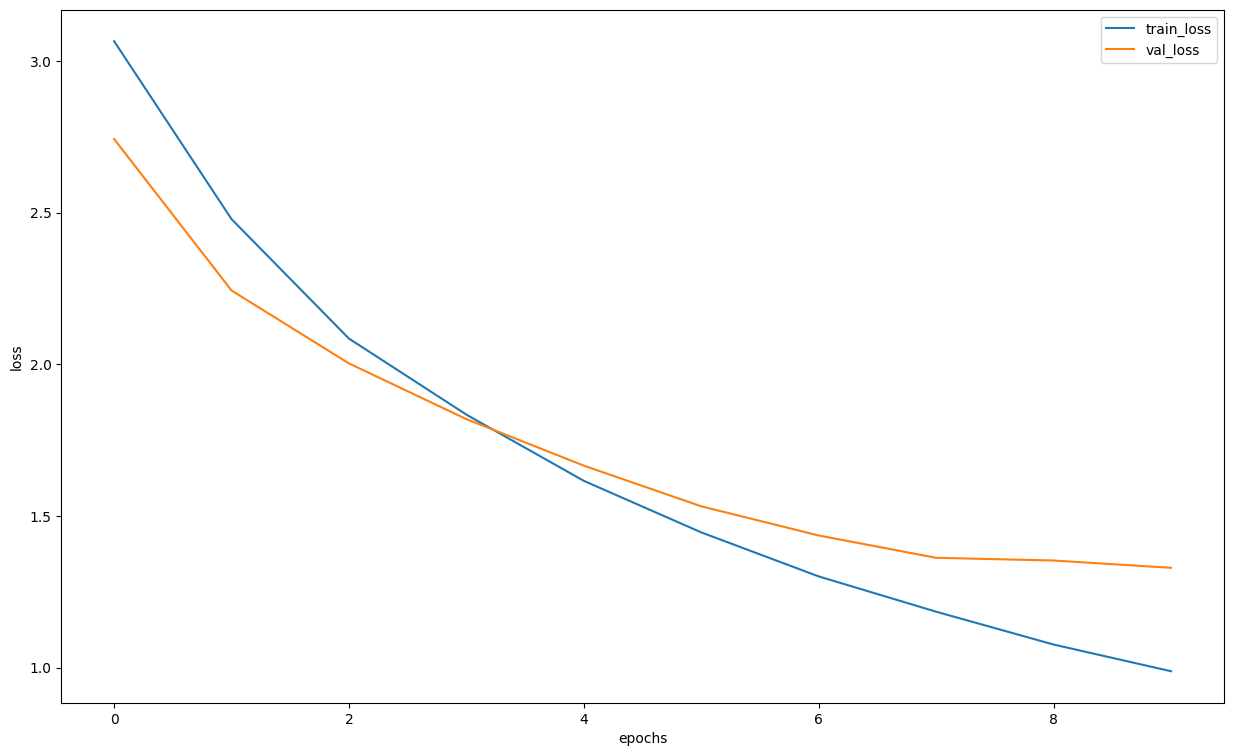

In [19]:
loss, acc, val_loss, val_acc = zip(*history3)

plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [20]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(device)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [21]:
label_encoder = pickle.load(open("/content/label_encode.pkl", 'rb'))

In [22]:
test_dataset = SpesialDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model, test_loader)
preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [23]:
import pandas as pd
# my_submit = pd.read_csv("gdrive/My Drive/labels.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()
!cd drive/My Drive && touch baseline.csv
my_submit.to_csv('drive/My Drive/baseline.csv', index=False)

/bin/bash: line 1: cd: too many arguments
